<a href="https://colab.research.google.com/github/MahdiNouraie/RNN-and-Transformers/blob/main/TFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyyaml==5.4.1

In [ ]:
!pip install darts

In [ ]:
!pip uninstall matplotlib

In [ ]:
pip install matplotlib==3.1.3

In [37]:
import darts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts.datasets import AirPassengersDataset
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mae, mape

In [19]:
from darts.timeseries import TimeSeries
airpass_ts = AirPassengersDataset().load()
airpass_ts.astype(np.float32)
index = TimeSeries.from_series(airpass_ts.time_index.days_in_month)
airpass_ts = airpass_ts / index

In [20]:
import datetime
airpass_train , airpass_val = airpass_ts.split_after(pd.Timestamp('19571201'))
sc = Scaler()
airpass_train_sc = sc.fit_transform(airpass_train)
airpass_val_sc = sc.transform(airpass_val)
airpass_ts_sc = sc.transform(airpass_ts)

cov = datetime_attribute_timeseries(airpass_ts , attribute = 'year' , one_hot = False)
cov = cov.stack(datetime_attribute_timeseries(airpass_ts , attribute = 'month' , one_hot = False))
cov = cov.stack(TimeSeries.from_times_and_values(times = airpass_ts.time_index,
                                                 values = np.arange(len(airpass_ts))
                        )
)
cov

<TimeSeries (DataArray) (Month: 144, component: 3, sample: 1)>
array([[[1.949e+03],
        [1.000e+00],
        [0.000e+00]],

       [[1.949e+03],
        [2.000e+00],
        [1.000e+00]],

       [[1.949e+03],
        [3.000e+00],
        [2.000e+00]],

       [[1.949e+03],
        [4.000e+00],
        [3.000e+00]],

       [[1.949e+03],
        [5.000e+00],
        [4.000e+00]],

...

       [[1.960e+03],
        [8.000e+00],
        [1.390e+02]],

       [[1.960e+03],
        [9.000e+00],
        [1.400e+02]],

       [[1.960e+03],
        [1.000e+01],
        [1.410e+02]],

       [[1.960e+03],
        [1.100e+01],
        [1.420e+02]],

       [[1.960e+03],
        [1.200e+01],
        [1.430e+02]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object 'year' 'month' '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [21]:
cov = cov.astype(np.float32)
sc2 = Scaler()
cov_train , cov_val = cov.split_after(pd.Timestamp('19571201'))
sc2.fit(cov_train)
cov_scaled = sc2.transform(cov)

In [17]:
from darts.models import TFTModel

In [22]:
tft_model = TFTModel(
    input_chunk_length = 20,
    output_chunk_length = 10,
    hidden_size = 100,
    lstm_layers = 2,
    num_attention_heads = 3,
    dropout = 0.1,
    n_epochs = 200
)

In [23]:
tft_model.fit(airpass_train_sc , future_covariates = cov_scaled)

2022-06-30 10:22:49 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 79 samples.
2022-06-30 10:22:49 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-06-30 10:22:49 pytorch_lightning.utilities.rank_zero INFO: GPU available: True, used: False
2022-06-30 10:22:49 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-06-30 10:22:49 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-06-30 10:22:49 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1817: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
2022-06-30 10:22:50 pytorch_lightning.callbacks.model_summary INFO: 
   | Name                              | Typ

Training: 0it [00:00, ?it/s]

In [39]:
def model_evaluation(model , n , actual_data, val_data):
  num_samples = 200
  quantile01 , quantile02, quantile03,quantile04 = (0.01,0.1,0.9,0.99)
  predicted_data = model.predict(n = n, num_samples = num_samples)
  
  plt.figure(figsize = (10,6))
  actual_data[:predicted_data.end_time()].plot(label = 'actual')

  predicted_data.plot(
      low_quantile = quantile01, 
      high_quantile = quantile04, 
      label = f"{int(quantile01*100)}-{int(quantile04*100)} th percentiles"
  )
  predicted_data.plot(
      low_quantile = quantile02, high_quantile = quantile03,label = f'{int(quantile02*100)}-{int(quantile03*100)} th percentiles'
  )
  plt.title(f"MAE:{mae(val_data, predicted_data)} , \
  MAPE:{mape(val_data, predicted_data)}")

Predicting: 3it [00:00, ?it/s]

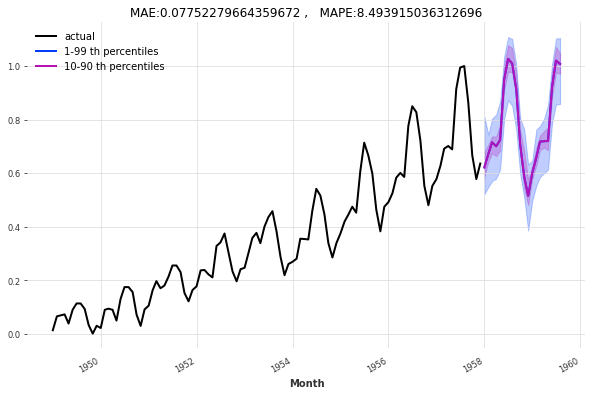

In [40]:
model_evaluation(tft_model , 20 , airpass_train_sc , airpass_val_sc)